# Мобильное приложение "Ненужные вещи"

Задача: по поведению пользователей определить слабые места в приложении.

## Содержание

- [Материалы](#шаг0.1)
- [Предоставленные данные](#шаг0.2)
- [Загрузка данных](#шаг0.3)
    - [Первичный анализ](#шаг0.04)
    - [Соответствуют ли предоставленные данные решаемой задаче?](#шаг0.05)
- [Предобработка](#шаг2)
    - [Соответствие типов данных](#шаг2.1)
    - [Переименование столбцов](#шаг2.2)
    - [Проверка на пропуски](#шаг2.3)
    - [неверные значения](#шаг2.4)
    - [дубликаты](#шаг2.5)
- [Исследовательский анализ](#шаг3)
    - [За какой период нам предоставлены данные?](#шаг3.1)
    - [Определение средних параметров по данным](#шаг3.2)
    - [Определение и фильтрация выбросов](#шаг3.3)
    - [Выводы по данным](#шаг3.4)
- [Выбор метрик](#шаг4)
    - [Выбор способа разбиения и методов (вручную/МО).](#шаг4.1)
    - [Создание дополнительных параметров на основе данных (для МО).](#шаг4.2)
    - [Выбор количества групп (для МО).](#шаг4.3)
    - [Сравнение метрик на группах](#шаг5)
    - [Составление сводной таблицы](#шаг5.1)
    - [Сравнительные графики](#шаг5.2)
- [Проверка статистических гипотез](#шаг6)
    - [Гипотеза для различных источников, из которых пользователи попали в приложение.](#шаг6.1)
    - [Собственная гипотеза](#шаг6.2)
    - [Выводы по гипотезам](#шаг6.3)
- [Общие выводы](#шаг7)
    - [Предобработка:](#шаг7.1)
    - [Исследовательский анализ:](#шаг7.2)
    - [Разбиение на группы](#шаг7.3)
    - [Проверка гипотез](#шаг7.4)
    - [Рекомендации для бизнеса](#шаг7.5)

### Материалы<a id='шаг0.1'></a>
**Ссылки на <a href='https://yadi.sk/i/IND21twQ3CbrzQ'>презентацию</a> и <a href='https://public.tableau.com/views/Unused_things/Final_prject_dashboard?:language=en&:display_count=y&publish=yes&:origin=viz_share_link'>дашборд</a>**

### Предоставленные данные:<a id='шаг0.2'></a>

Датасет **mobile_dataset.csv** содержит колонки:
- `event.time` — время совершения
- `event.name` — название события
- `user.id` — идентификатор пользователя

Датасет **mobile_sources.csv** содержит колонки:
- `userId` — идентификатор пользователя
- `source` — источник, с которого пользователь установил приложение

Расшифровки событий:
- `advert_open` — открытие карточки объявления
- `photos_show` — просмотр фотографий в объявлении
- `tips_show` — пользователь увидел рекомендованные объявления
- `tips_click` — пользователь кликнул по рекомендованному объявлению
- `contacts_show` и `show_contacts` — пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления
- `contacts_call` — пользователь позвонил по номеру телефона на карточке объявления
- `map` — пользователь открыл карту размещенных объявлений
- `search_1` — `search_7` — разные события, связанные с поиском по сайту
- `favorites_add` — добавление объявления в избранное

### Загрузка данных<a id='шаг0.3'></a>

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
from scipy import stats as st
import math as mth

from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
# варианты загрузки данных: локальная и через тренажер
try:
    data = pd.read_csv('/datasets/mobile_dataset.csv')
    srs = pd.read_csv('/datasets/mobile_soures.csv')
except:
    data = pd.read_csv('datasets/mobile_dataset.csv')
    srs = pd.read_csv('datasets/mobile_soures.csv')

#### Первичный анализ<a id='шаг0.04'></a>

- Лог по событиям:

In [3]:
display(data.head())
data.info()

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


В таблице содержатся данные о событиях, совершаемых пользователями в приложении. Пропусков нет, столбец с датой требует изменения типа данных.

- Источники, по которым пользователи попали в приложение:

In [4]:
display(srs.head())
srs.info()

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


Во второй таблице содержится информация об источниках, из которых пользователи попали в приложение. Пропусков так же нет, нет и ошибочных типов данных.

#### Соответствуют ли предоставленные данные решаемой задаче?<a id='шаг0.05'></a>

Да, по предоставленным данным можно проанализировать поведение пользователей.

## Шаг 1. Предобработка<a id='шаг2'></a>

Проведу более глубокий анализ данных на предмет ошибочных значений.

#### Соответствие типов данных<a id='шаг2.1'></a>

Исправлю тип данных даты в таблице с событиями пользователей:

In [5]:
data['event.time'] = pd.to_datetime(data['event.time'], format='%Y-%m-%d %H:%M:%S.%f')
display(data.head())
data.info()

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event.time  74197 non-null  datetime64[ns]
 1   event.name  74197 non-null  object        
 2   user.id     74197 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


#### Переименование столбцов<a id='шаг2.2'></a>

Приведу названия столбцов к однообразному виду:

In [6]:
srs = srs.rename({'userId': 'user.id', 'source': 'user.source'}, axis=1)
srs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user.id      4293 non-null   object
 1   user.source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


#### Проверка на пропуски<a id='шаг2.3'></a>

Пропусков нет, проверил ранее.

#### Неверные значения<a id='шаг2.4'></a>

- Таблица событий

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event.time  74197 non-null  datetime64[ns]
 1   event.name  74197 non-null  object        
 2   user.id     74197 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


In [8]:
# время события
data['event.time'].describe()

count                          74197
unique                         74197
top       2019-10-20 20:53:28.313292
freq                               1
first     2019-10-07 00:00:00.431357
last      2019-11-03 23:58:12.532487
Name: event.time, dtype: object

Первое событие в базе от 7 октября, последнее - 3 ноября 2019 года, т.е. вся база охватывает промежуток чуть меньше месяца.

In [9]:
# типы событий:
data['event.name'].value_counts()

tips_show        40055
photos_show      10012
advert_open       6164
contacts_show     4450
map               3881
search_1          3506
favorites_add     1417
search_5          1049
tips_click         814
search_4           701
contacts_call      541
search_3           522
search_6           460
search_2           324
search_7           222
show_contacts       79
Name: event.name, dtype: int64

События соответствуют представленным в задании, переименую дубликат события для показа контактов:

In [10]:
data.loc[data['event.name'] == 'show_contacts', 'event.name'] = 'contacts_show'
data['event.name'].value_counts()

tips_show        40055
photos_show      10012
advert_open       6164
contacts_show     4529
map               3881
search_1          3506
favorites_add     1417
search_5          1049
tips_click         814
search_4           701
contacts_call      541
search_3           522
search_6           460
search_2           324
search_7           222
Name: event.name, dtype: int64

#### Дубликаты<a id='шаг2.5'></a>

In [11]:
data.duplicated().sum()

0

In [12]:
srs.duplicated().sum()

0

Дубликаты отсутствуют.

- Таблица источников

In [13]:
srs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user.id      4293 non-null   object
 1   user.source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


In [14]:
# типы источников
srs['user.source'].value_counts()

yandex    1934
other     1230
google    1129
Name: user.source, dtype: int64

3 типа, и есть некоторый неопределенный `other`

Проверка на наличие в таблице источников данных обо всех пользователях:


In [15]:
# количество пользователей в таблице с событиями:
data['user.id'].nunique()

4293

In [16]:
# количество пользователей в таблице с источниками:
srs['user.id'].nunique()

4293

In [17]:
# количество совпадает, проверим соответствие:
data_users = data['user.id'].unique()
srs_users = srs['user.id'].unique()
# добавить только тех пользователей, которых не удалось найти в таблице источников:
[user for user in data_users if user not in srs_users]

[]

Данные обо всех пользователях полные.

Вывод: данные о пользователях соответвуют поставленной задаче, отсутствуют дубликаты и неверные значения. Пришлось привести дату к нужному типу (был строковый). Для удобства также были переименованы названия столбцов, дубликат события `показать контакты`.

## Шаг 2. Исследовательский анализ<a id='шаг3'></a>

Исследую структуру предоставленных данных.

#### За какой период нам предоставлены данные?  <a id='шаг3.1'></a>

In [18]:
print('Данные предоставлены за период с {} по {}.'
      .format(data['event.time'].dt.date.min(), data['event.time'].dt.date.max()))

Данные предоставлены за период с 2019-10-07 по 2019-11-03.


In [19]:
data['event.time'] = pd.to_datetime(data['event.time'])

In [20]:
data['event.time'].head()

0   2019-10-07 00:00:00.431357
1   2019-10-07 00:00:01.236320
2   2019-10-07 00:00:02.245341
3   2019-10-07 00:00:07.039334
4   2019-10-07 00:00:56.319813
Name: event.time, dtype: datetime64[ns]

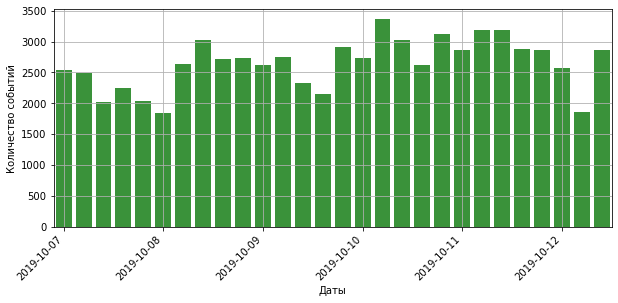

In [21]:
# график распределения

data['event.time.norm'] = data['event.time'].dt.strftime('%Y-%m-%d')
days = data['event.time.norm'].nunique()
fig, ax = plt.subplots(figsize=(10,4))
sns.countplot(data['event.time.norm'], color='tab:green')
plt.xticks(rotation=45, ha='right')
plt.grid()
plt.xlabel('Даты')
plt.xticks(range(0,days,5))
plt.ylabel('Количество событий')
plt.show()

Данные распределены довольно равномерно.

#### Определение средних параметров по данным  <a id='шаг3.2'></a>

In [22]:
users_stat = data.groupby('user.id')['event.name'].value_counts(dropna=False)
users_stat.groupby('event.name').mean().sort_values(ascending=False)

event.name
tips_show        14.300250
photos_show       9.143379
advert_open       8.207723
contacts_show     4.616718
search_1          4.454892
favorites_add     4.037037
map               2.665522
contacts_call     2.539906
tips_click        2.527950
search_3          2.509615
search_5          1.582202
search_4          1.478903
search_7          1.414013
search_6          1.393939
search_2          1.338843
Name: event.name, dtype: float64

В среднем каждый пользователь 14 раз видит рекомендованные объявления, 9 раз - фотографии в объявлении, 8 объявлений открывает. Это наиболее популярные действия для пользователей в среднем.

#### Определение и фильтрация выбросов  <a id='шаг3.3'></a>

In [23]:
# сброс индекса
users_stat = users_stat.rename('count').reset_index()

In [24]:
# задание порядка - по убыванию медиан количества событий
events_order = users_stat.groupby('event.name')['count'].median().sort_values(ascending=False).index

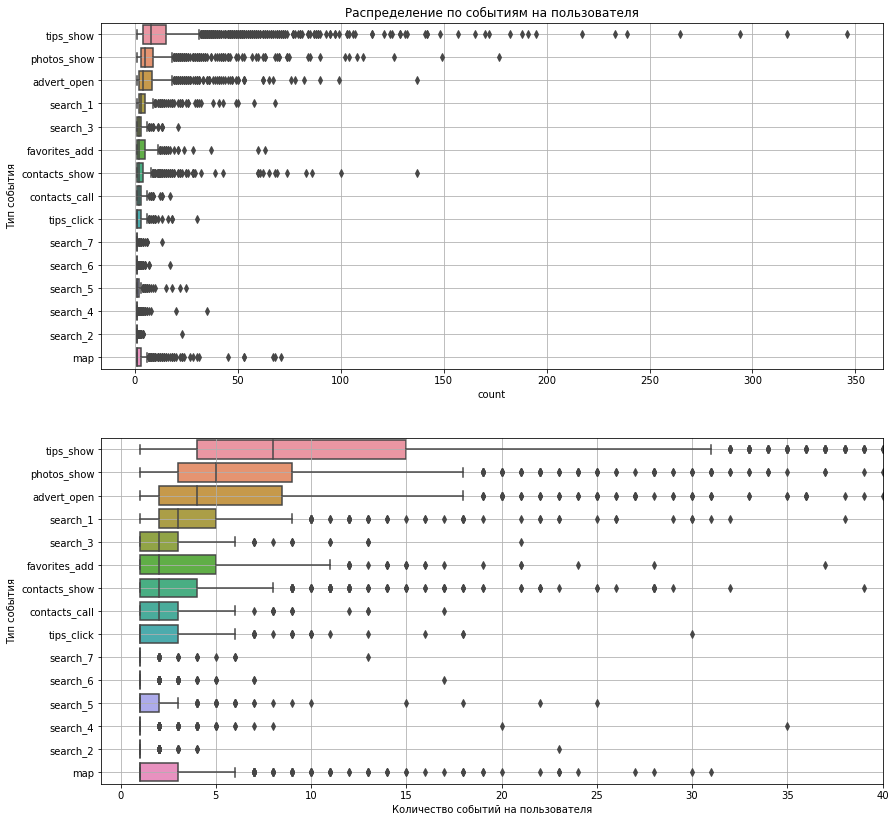

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14,14))
ax[0].set_title('Распределение по событиям на пользователя')
sns.boxplot(y='event.name', x='count', data=users_stat, order=events_order, ax=ax[0])
ax[0].grid()
sns.boxplot(y='event.name', x='count', data=users_stat, order=events_order, ax=ax[1])
plt.xlim(-1,40)
ax[0].set_ylabel('Тип события')
ax[1].grid()
plt.xlabel('Количество событий на пользователя')
ax[1].set_ylabel('Тип события')
plt.show()

Есть активные пользователи, которые совершили до 350 действий. За месяц это не так много и явно меньше, чем могли бы совершить поисковые роботы или иные скрипты. Поэтому все данные оставляю.

#### Общие выводы по данным<a id='шаг3.4'></a>

Данные предоставлены почти за месяц, с 7 октября 2019 по 3 ноября 2019 включительно. События по датам распределены достаточно равномерно, следовательно, нет проблем с потерей данных.
Пользователей больше привлекают рекомендованные объявления (14 в среднем) и фотографии в объявлениях (9 в среднем на пользователя).  
Карты показываются в среднем менее 3 раз на пользователя.

## Шаг 3. Выбор метрик<a id='шаг4'></a>

#### Выбор способа разбиения и методов (вручную/МО).  <a id='шаг4.1'></a>

Буду смотреть итоговые метрики вручную в разрезе всех действий пользователей. Чтобы не влияли выбросы, буду использовать медианные значения для разделения.

### Определение метрик
#### 1. retention rate
На данном сокращенном наборе данных (менее месяца) полноценно посчитать `retention rate` не представляется возможным, использую упрощённую метрику - возврат пользователя через неделю.

In [26]:
def is_returned_rate(sessions_data):
    """
    Функция определяет, совершал ли пользователь хотя бы одно событие через неделю после первого
    
    Передаваемые данные - массив из нескольких таблиц для сравнения
    """
    ar = []
    for i, d in enumerate(sessions_data):
        # предварительная сортировка по пользователям и времени для корректного измерения времени от предыдущего события
        d = d.sort_values(by=['user.id', 'event.time'])
        g = d.groupby('user.id') # вспомогательная группировка

        # добавляю колонку со временем первого события пользователя
        d = d.merge(g['event.time'].min().rename('first_user_time'), left_on='user.id', right_index=True)

        # колонка со временем для каждого пользователя, прошедшего со времени его первого события
        d['user_time'] = d['event.time'] - d['first_user_time']

        # минимальное время для первого события пользователя для того, чтобы можно было
        # узнать, вернулся ли он через неделю (+1 день запаса)
        min_first_user_time = data['event.time'].max() - pd.Timedelta('8 days')

        # отсекаю пользователей, по которым невозможно сказать, пришли ли они через неделю:
        ret_data = d[d['first_user_time'] < min_first_user_time]

        # процент пользователей, посетивших приложение спустя неделю или более
        ar.append(np.mean(ret_data.groupby(['user.id'])['user_time'].max() > '7 days'))
    return ar

#### 2. время, проведённое в приложении. 

Приму за сессию время = 30 минутам.

In [27]:
# НУМЕРАЦИЯ СЕССИЙ ДЛЯ ПОЛЬЗОВАТЕЛЕЙ
data['prev_event_time'] = data.sort_values(by=['user.id','event.time']).groupby('user.id')['event.time'].shift(1)

# измерение временной задержки от предыдущего действия
data['time_lag'] = (data['event.time'] - data['prev_event_time'])

g = data.groupby('user.id')
# нумерация сессий: определение, больше ли задержка 30 минут, и если да, то прибавление 1 к номеру сессии
data['session'] = g['time_lag'].apply(lambda x: (x > '30 minutes').cumsum())

In [28]:
def get_user_total_time_table(sessions_data):
    """
    Вспомогательная функция для определения суммарного пользовательского времени в приложении для сессий = 30 минут.
    """

    # группировка по пользователям и по их сессиям
    gs = sessions_data.groupby(['user.id','session'])
    
    # определение длины каждой сессии и суммирование для каждого пользователя
    users_sessions_total_time = (gs['event.time'].max() - gs['event.time'].min()).sum(level='user.id')
    return users_sessions_total_time

In [29]:
def get_user_total_time(sessions_data):
    """Определение медианного времени пользователя в приложении
    
    Передаваемые данные - массив из нескольких таблиц для сравнения
    """
    ar = []
    for i, d in enumerate(sessions_data):
        time_table = get_user_total_time_table(d)
#         sns.distplot(time_table)
#         print('Медианное время пользователей в {} группе: {:.1f}'.format(i+1, time_table.median().seconds / 60))
#     plt.show()
        ar.append(time_table.median().seconds / 60)
    return ar

#### 3. частота действий

In [30]:
def get_freq(sessions_data):
    """Определение медианной частоты действий пользователя в приложении
    
    Передаваемые данные - массив из нескольких таблиц для сравнения
    """
    ar = []
    for i, d in enumerate(sessions_data):
        time_table = get_user_total_time_table(d)

        users_sessions_freq = time_table.to_frame('events.time')
        users_sessions_freq['user.events'] = data.groupby('user.id')['event.name'].count()
        users_sessions_freq['frequency'] = users_sessions_freq['events.time'] / users_sessions_freq['user.events']
#         sns.distplot(users_sessions_freq['frequency'])
#         print('Для {} набора данных медианная частота действий пользователей: {:.1f} минут'
#           .format(i+1, users_sessions_freq['frequency'].median().seconds / 60))
        ar.append(3600 / users_sessions_freq['frequency'].median().seconds)
#     plt.show()
    return ar

In [31]:
def count_successes_trials(target_data):
    # дополнительный столбец с проверкой на целевое действие
    target_data['is_target'] = target_data['event.name'] == 'contacts_show'
    # если у пользователя есть хотя бы одно целевое действие - он идёт в зачёт, а потом считается среднее
#         print('Для {} набора данных конверсия в просмотр контактов: {:.2%}'.format(i+1, d.groupby('user.id')['is_target'].any().mean()))
    users_sessions = target_data.groupby(['user.id','session'])['is_target'].count()
#         количество целевых событий пользователя (не более одного за сессию):
    users_targets = target_data.groupby(['user.id','session'])['is_target'].any()
    return (users_targets, users_sessions)

In [32]:
# 4. конверсия в целевое действие — просмотр контактов.
def target_conversion(target_data):
    """Определение итоговой конверсии в целевое действие "просмотр контактов"
    
    Передаваемые данные - массив из нескольких таблиц для сравнения
    """
    ar = []
    for i, d in enumerate(target_data):
        (users_targets, users_sessions) = count_successes_trials(d)
        target_conv_stat = users_targets / users_sessions
#         итоговая метрика как усреднение данных сначала по пользователям, а потом и в целом
        target_conv = target_conv_stat.groupby('user.id').mean().mean()
        ar.append(target_conv)
    return ar

### Сравнение метрик на группах<a id='шаг5'></a>

#### Разбиваю пользователей вручную по каждому событию (много/мало) относительно медианы, т.к. есть много очень больших "хвостов" измеряемых величин:

In [33]:
events_data = data.groupby(['user.id','event.name'])['event.name'].count().rename('count').reset_index()
events_data.head()

,user.id,event.name,count
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,map,6
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,tips_show,29
2,00157779-810c-4498-9e05-a1e9e3cedf93,advert_open,2
3,00157779-810c-4498-9e05-a1e9e3cedf93,contacts_call,5
4,00157779-810c-4498-9e05-a1e9e3cedf93,contacts_show,11


In [34]:
events_dict = events_data.groupby('event.name')['count'].median().to_dict()
events_dict

{'advert_open': 4,
 'contacts_call': 2,
 'contacts_show': 2,
 'favorites_add': 2,
 'map': 1,
 'photos_show': 5,
 'search_1': 3,
 'search_2': 1,
 'search_3': 2,
 'search_4': 1,
 'search_5': 1,
 'search_6': 1,
 'search_7': 1,
 'tips_click': 1,
 'tips_show': 8}

#### Составление сводной таблицы  <a id='шаг5.1'></a>

In [35]:
ev_list = events_dict
# удаление целевых событий из признаков для сравнения
ev_list.pop('contacts_show', None)
ev_list.pop('contacts_call', None)

pivot = pd.DataFrame(columns=[
    'events',
    'sets',
    'returned_rate',
    'total_time_median',
    'frequency_median',
    'target_conversion'
])

for i, ev in enumerate(ev_list):
#     делю исходные данные на 2 части - пользователи, которые
#     совершали медианное количество действий данного типа или меньше, и - больше
    print('Подсчет статистики для ' + ev + '...')
#     список пользователей, совершивших событий меньше или равно медианному:
    users_list_low = events_data[(events_data['event.name'] == ev)&
                                 (events_data['count'] <= events_dict[ev])]['user.id'].unique()
    data_low = data[data['user.id'].isin(users_list_low)]
    data_high = data[~data['user.id'].isin(users_list_low)]
#     подсчет значений метрик через соответствующие функции
    irr = is_returned_rate([data_low, data_high])
    utt = get_user_total_time([data_low, data_high])
    fr = get_freq([data_low, data_high])
    tc = target_conversion([data_low, data_high])
    
#     сводная таблица - для каждого типа событий создается 2 строки:
#     для пользователей, часто совершавших действие (больше медианного) и меньше
#     вначале тип метрики и группа (редко/часто), потом значения метрик
    pivot.loc[i*2] =   [ev,'low',irr[0],utt[0],fr[0],tc[0]] # четные строки - пользователи, редко совершавшие данные события
    pivot.loc[i*2+1] = [ev,'high',irr[1],utt[1],fr[1],tc[1]] # нечетные - часто
pivot

Подсчет статистики для advert_open...
Подсчет статистики для favorites_add...
Подсчет статистики для map...
Подсчет статистики для photos_show...
Подсчет статистики для search_1...
Подсчет статистики для search_2...
Подсчет статистики для search_3...
Подсчет статистики для search_4...
Подсчет статистики для search_5...
Подсчет статистики для search_6...
Подсчет статистики для search_7...
Подсчет статистики для tips_click...
Подсчет статистики для tips_show...


,events,sets,returned_rate,total_time_median,frequency_median,target_conversion
0,advert_open,low,0.188679,12.483333,48.648649,0.014282
1,advert_open,high,0.192636,15.400000,41.379310,0.036399
2,favorites_add,low,0.345455,21.700000,37.894737,0.052492
3,favorites_add,high,0.184057,14.800000,42.352941,0.033357
4,map,low,0.135823,13.950000,45.569620,0.017512
5,map,high,0.204733,15.366667,41.379310,0.037805
6,photos_show,low,0.162896,8.900000,42.857143,0.065556
7,photos_show,high,0.196867,16.366667,41.860465,0.029248
8,search_1,low,0.171429,12.916667,38.297872,0.055831
9,search_1,high,0.194760,15.366667,42.352941,0.031763


In [36]:
# приведение к вертикальному виду
pivot = pivot.set_index(['events', 'sets']).stack().reset_index().rename({'level_2':'metrics',0:'value'},axis=1)
pivot.head()

,events,sets,metrics,value
0,advert_open,low,returned_rate,0.188679
1,advert_open,low,total_time_median,12.483333
2,advert_open,low,frequency_median,48.648649
3,advert_open,low,target_conversion,0.014282
4,advert_open,high,returned_rate,0.192636


#### Сравнительные графики  <a id='шаг5.2'></a>

returned_rate


sets,high,low
events,,
favorites_add,0.184057,0.345455
tips_click,0.188239,0.295082
search_3,0.190143,0.254717
search_2,0.189922,0.238710
search_7,0.191079,0.233333
search_6,0.192005,0.195980
advert_open,0.192636,0.188679
search_4,0.192645,0.188153
search_5,0.194675,0.172702


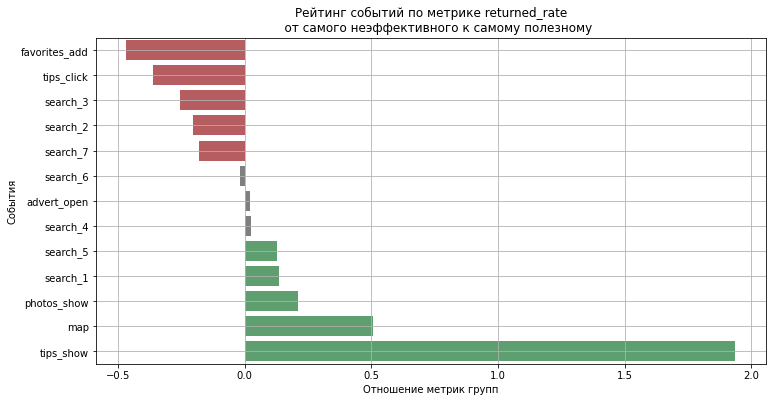

total_time_median


sets,high,low
events,,
tips_click,14.550000,27.500000
favorites_add,14.800000,21.700000
search_3,14.966667,21.850000
search_2,15.000000,16.550000
search_4,15.000000,15.233333
search_7,15.116667,14.216667
map,15.366667,13.950000
search_5,15.383333,13.200000
search_1,15.366667,12.916667


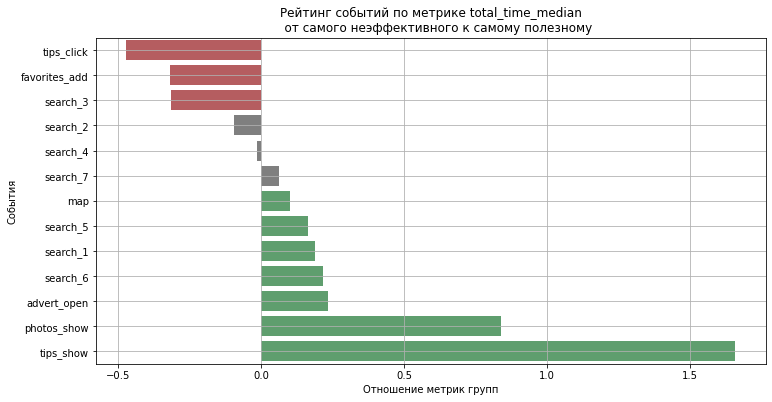

frequency_median


sets,high,low
events,,
search_2,41.379310,58.064516
search_3,41.379310,56.250000
search_6,41.379310,55.384615
search_7,41.860465,54.545455
search_5,41.379310,53.731343
search_4,41.379310,51.428571
tips_show,40.000000,47.368421
advert_open,41.379310,48.648649
map,41.379310,45.569620


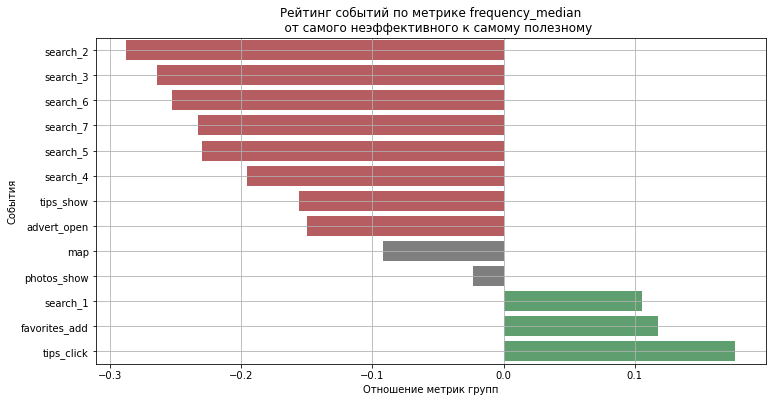

target_conversion


sets,high,low
events,,
photos_show,0.029248,0.065556
search_1,0.031763,0.055831
favorites_add,0.033357,0.052492
search_7,0.034588,0.024827
tips_show,0.040622,0.022888
tips_click,0.034934,0.018171
map,0.037805,0.017512
search_2,0.035193,0.015369
advert_open,0.036399,0.014282


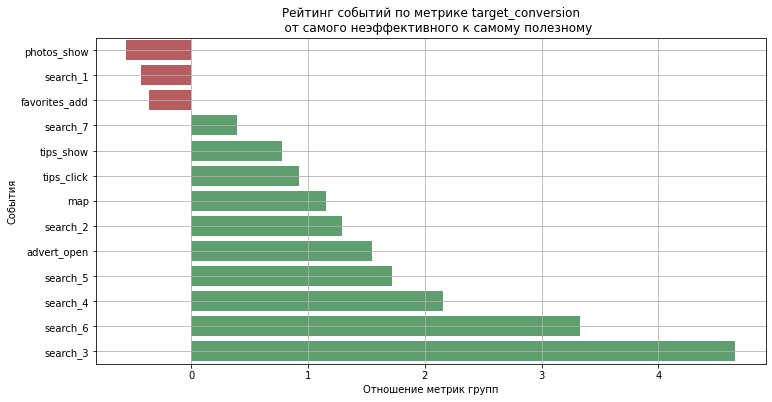

In [37]:
pivot_rel = (pivot
.groupby(['metrics','events'])
.apply(lambda x: x['value'].iloc[1] / x['value'].iloc[0] - 1)
.rename('rel')
.reset_index()
.sort_values(by='rel')
)

palette = sns.color_palette('deep')

# сравнение групп пользователей по каждой метрике
for m in ['returned_rate', 'total_time_median', 'frequency_median', 'target_conversion']:
    print(m)
    metrics_df = pivot_rel[pivot_rel['metrics'] == m]
    piv = pivot[pivot['metrics'] == m].pivot_table(index='events',
                                                   columns='sets',
                                                   values='value',
                                                   aggfunc='sum')\
    .reindex(metrics_df['events'].tolist())
    display(piv)
#     условное форматирование
    colors_list = ['tab:grey' if abs(rel) < 0.1 else
                   (palette[3] if rel < 0 else palette[2])
                   for rel in metrics_df['rel']]
    
    fig, ax = plt.subplots(figsize=(12,6))
    sns.barplot(y='events', x='rel', data=pivot_rel[pivot_rel['metrics'] == m], palette=colors_list)
    plt.title('Рейтинг событий по метрике {}\n\
    от самого неэффективного к самому полезному'.format(m))
    plt.ylabel('События')
    plt.xlabel('Отношение метрик групп')
    plt.grid()
    plt.show()

Выводы: в большинстве случаев нельзя однозначно сказать, что что-то в приложении работает не так. 

Хуже всего возвращаются (через неделю) пользователи, которые:
- чаще добавляли предложения в избранное
    - возможно, они нашли то, что искали, но не решились сразу купить. Это не говорит об их недовольстве функционалом приложения.
- чаще кликали на предлагаемую рекламу
    - возможно, тоже находили что нужно в рекламе
- пользовались поиском 3, 2, 7
    - поиск позволял находить нужное

Меньше всего проводят времени в приложении:
- те, кто чаще кликали на предлагаемую рекламу,
- чаще добавляли предложения в избранное,
    - откладывали на будущее, интервал наблюдения слишком мал
- пользовались поиском 3
    - возможно, он работает даже лучше других поисков

Реже всего пользуются, если:
- чаще пользовались поиском 2,3,6,7,5,4
    - быстро находили нужное?
- им показывали предложения
    - то, что нужно?
- они открывали рекламу

Меньше всего целевая конверсия у тех, кто:
- смотрел фото
- пользовался поиском 1
- добавлял объявления в избранное

Довольно странной является работа поиска 1, который в отличие от других приводит к проигрышу в конверсии в целевые действия. Стоит так же проверить корректность отображения фотографий и возможность вернуться в приложение после просмотра рекламы.

## Шаг 4. Проверка статистических гипотез<a id='шаг6'></a>

### Гипотеза для различных источников, из которых пользователи попали в приложение.<a id='шаг6.1'></a>
- H0 конверсия пользователей из `yandex` и `google` не различается
- H1: различается  

Уровень критической статистической значимости p возьму за 5%.

Определение, было ли целевое действие - просмотр контактов?

In [38]:
users_targets = data[data['event.name'] == 'contacts_show'].groupby('user.id')['event.name'].count().reset_index()
print('Процент пользователей, которые совершили целевое действие, в целом: {:.2%}'.format(users_targets.shape[0] / data_users.shape[0]))

Процент пользователей, которые совершили целевое действие, в целом: 22.85%


In [39]:
# посчитаю процент пользователей по источникам в отдельности:
users_ts = users_targets.merge(srs, left_on='user.id', right_on='user.id', how='right')
users_ts = users_ts.fillna(0)
users_ts.loc[users_ts['event.name'] > 1, 'event.name'] = 1
users_ts.groupby('user.source')['event.name'].mean()

user.source
google    0.243578
other     0.185366
yandex    0.247156
Name: event.name, dtype: float64

Как видно, Яндекс и Гугл практически не отличаются друг от друга по конверсии, проседает относительно них "другой" источник. Проверю, есть ли отличия с т.з. статистики. Использую метод для сравнения долей:

##### Проверка гипотезы  

Подсчет нужной статистики для сравнения долей:

In [40]:
yand_sc = users_ts[users_ts['user.source'] == 'yandex']['event.name'].sum()
yand_tr = users_ts[users_ts['user.source'] == 'yandex'].shape[0]
goo_sc = users_ts[users_ts['user.source'] == 'google']['event.name'].sum()
goo_tr = users_ts[users_ts['user.source'] == 'google'].shape[0]
print('Яндекс: пользователей {}, посмотрели контакты {}'.format(yand_tr, yand_sc))
print('Гугл: пользователей {}, посмотрели контакты {}'.format(goo_tr, goo_sc))

Яндекс: пользователей 1934, посмотрели контакты 478.0
Гугл: пользователей 1129, посмотрели контакты 275.0


In [41]:
def frac_compare(successes, trials, alpha=0.05):

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

alpha = .05 # критический уровень статистической значимости
successes = np.array([yand_sc, goo_sc])
trials = np.array([yand_tr, goo_tr])
frac_compare(successes, trials, alpha)

p-значение:  0.8244316027993777
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


### Собственная гипотеза.<a id='шаг6.2'></a>
- Конверсия пользователей по источникам `Яндекс` и `другое` различаются
- Не различаются  

Уровень критической статистической значимости p возьму за 5%.

##### Проверка гипотезы  

In [42]:
yand_sc = users_ts[users_ts['user.source'] == 'yandex']['event.name'].sum()
yand_tr = users_ts[users_ts['user.source'] == 'yandex'].shape[0]
oth_sc = users_ts[users_ts['user.source'] == 'other']['event.name'].sum()
oth_tr = users_ts[users_ts['user.source'] == 'other'].shape[0]
print('Яндекс: пользователей {}, посмотрели контакты {}'.format(yand_tr, yand_sc))
print('Другое: пользователей {}, посмотрели контакты {}'.format(oth_tr, oth_sc))

Яндекс: пользователей 1934, посмотрели контакты 478.0
Другое: пользователей 1230, посмотрели контакты 228.0


In [43]:
alpha = .05 # критический уровень статистической значимости
successes = np.array([yand_sc, oth_sc])
trials = np.array([yand_tr, oth_tr])

frac_compare(successes, trials, alpha)

p-значение:  4.7142597613403225e-05
Отвергаем нулевую гипотезу: между долями есть значимая разница


#### Выводы  по гипотезам<a id='шаг6.3'></a>

Между долями пользователей, которые приходят из разных источников, нет статистически значимой разницы в конверсии в целевое действие `посмотреть контакты` между Яндексом и Гуглом, но есть - между Яндексом и другими источниками - у Яндекса значимо больше (более 24%).

## Шаг 5. Выводы<a id='шаг7'></a>

#### Предобработка:<a id='шаг7.1'></a>
Данные о пользователях соответвуют поставленной задаче, отсутствуют дубликаты и неверные значения. Пришлось привести дату к нужному типу (был строковый). Для удобства также были переименованы названия столбцов, дубликат события `показать контакты`.

#### Исследовательский анализ:<a id='шаг7.2'></a>
Данные предоставлены почти за месяц, с 7 октября 2019 по 3 ноября 2019 включительно. События по датам распределены достаточно равномерно, следовательно, нет проблем с потерей данных. Пользователей больше привлекают рекомендованные объявления (14 в среднем) и фотографии в объявлениях (9 в среднем на пользователя).
Карты показываются в среднем менее 3 раз на пользователя.

#### Разбиение на группы<a id='шаг7.3'></a>
В большинстве случаев нельзя однозначно сказать, что что-то в приложении работает не так. 

Хуже всего возвращаются (через неделю) пользователи, которые:
- чаще добавляли предложения в избранное
    - возможно, они нашли то, что искали, но не решились сразу купить. Это не говорит об их недовольстве функционалом приложения.
- чаще кликали на предлагаемую рекламу
    - возможно, тоже находили что нужно в рекламе
- пользовались поиском 3, 2, 7
    - поиск позволял находить нужное

Меньше всего проводят времени в приложении:
- те, кто чаще кликали на предлагаемую рекламу,
- чаще добавляли предложения в избранное,
    - откладывали на будущее?, интервал наблюдения слишком мал
- пользовались поиском 3
    - возможно, он работает даже лучше других поисков

Реже всего пользуются, если:
- чаще пользовались поиском 2,3,6,7,5,4
    - быстро находили нужное?
- им показывали предложения
    - то, что нужно?
- они открывали рекламу

Меньше всего целевая конверсия у тех, кто:
- смотрел фото
- пользовался поиском 1
- добавлял объявления в избранное

#### Проверка гипотез<a id='шаг7.4'></a>
Между долями пользователей, которые приходят из разных источников, нет статистически значимой разницы в конверсии в целевое действие посмотреть контакты между Яндексом и Гуглом, но есть - между Яндексом и другими источниками - у Яндекса значимо больше (более 24%).

#### Рекомендации для бизнеса<a id='шаг7.5'></a>
- Довольно странной является работа **поиска 1**, который в отличие от других приводит к проигрышу в конверсии в целевые действия.
- Стоит так же проверить **корректность отображения фотографий** и возможность вернуться в приложение после просмотра **рекламы**.
- Пользователи, которые добавили что-то в **избранное** и не заходят - возможно, забыли и им стоит **напомнить** про их выбор?
- Использовать продвижение в **Яндексе** и **Гугле**, т.к. они приводят более лояльную аудиторию.